## General Procedure

### 0) Import Libs
### 1) Variable Analysis & Treatment
### 2) Selection of Variables
### 3) Check for best estimators (on a cross-validation)
### 4) Apply GridSearchCV on best estimator
### 5) Validate model on a simulation dataframe


### Note: XGBoost is not installed on my home laptop, so I used in the end of this script an sklearn gradient boosting function, which is not as optimized as XGBoost. I also had to install a tokenisation package to simplify some data manipulation. I tried to be as clear as possible during the development of the model, however due to time constraints more detailed tests were not done.

### 0) import libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### read csv file

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,User ID,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7
0,WUPRXZY2OAYGIXAHXKQH,2.038018,-1.106244,0.021878,1.060334,-0.564777,mat cat cat cat mat mat sat mat,0
1,WUPRXZY2OAYGIXAHXKQH,2.035986,-0.896107,0.120867,0.869520,-0.597180,mat cat sat mat mat mat,0
2,WUPRXZY2OAYGIXAHXKQH,2.041360,-1.168841,0.367205,0.935036,-0.637703,sat sat sat cat mat mat,0
3,WUPRXZY2OAYGIXAHXKQH,2.031916,-1.010094,0.370151,1.146873,-0.740995,cat sat cat cat cat cat mat mat cat,0
4,WUPRXZY2OAYGIXAHXKQH,2.036207,-1.132448,0.137019,1.005982,-0.442618,sat sat cat sat mat cat mat mat sat,0


### 1) Variable Analysis & Treatment

#### define a simple function to verify some types of variables (variable treatment ...)

In [4]:
def parametros_da_base(df):
 
    description = df.describe(include='all')
   
    print('number of variables per criterion:')
    print('')
    ### Desvio padrão == 0; variáveis com único valor preenchido e sem NaN
    print('std = 0 s/ NaN:',
          df.loc[:,(list(description.loc['std',:] == 0)) & (description.loc['count',:]==df.shape[0])].shape[1])
    ### Desvio padrão ==0; variáveis com um único valor preenchido e COM NaN
    print('std = 0 c/ NaN:',
          df.loc[:,(list(description.loc['std',:] == 0)) & (description.loc['count',:]!=df.shape[0])].shape[1])
    ### Variáveis com todas observações com valores NaN
    print('std = 0, other cases (check):',
          df.loc[:,(list(description.loc['std',:].isnull())) & (description.loc['count',:]!=df.shape[0])].shape[1])
    print('other variables:',
          df.loc[:,list((description.loc['std',:] != 0) & (~description.loc['std',:].isnull()))].shape[1])
   
    avalia_1 = df.loc[:,(list(description.loc['std',:] == 0)) & (description.loc['count',:]==df.shape[0])].columns.values
    avalia_2 = df.loc[:,(list(description.loc['std',:] == 0)) & (description.loc['count',:]!=df.shape[0])].columns.values
    avalia_3 = df.loc[:,(list(description.loc['std',:].isnull())) & (description.loc['count',:]!=df.shape[0])].columns.values
   
    exclui_variaveis = {}
    exclui_variaveis['type1'] = avalia_1
    exclui_variaveis['type2'] = avalia_2
    exclui_variaveis['type3'] = avalia_3
   
    return exclui_variaveis

#### evaluate standard deviation, NaN, etc. $\rightarrow$ only 'Feature 6' seems to have something interesting going on ...

In [5]:
parametros_da_base(df)

number of variables per criterion:

std = 0 s/ NaN: 0
std = 0 c/ NaN: 0
std = 0, other cases (check): 1
other variables: 6


{'type1': array([], dtype=object),
 'type2': array([], dtype=object),
 'type3': array(['Feature 6'], dtype=object)}

#### check missing values $\rightarrow$ most of the dataset is complete $\rightarrow$ not much work to do ...

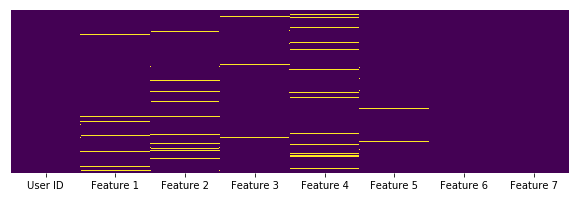

In [6]:
import seaborn as sns

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,3))         
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis',ax=ax)

#### working on 'Feature 6' (double check for NaN)

In [7]:
df.loc[df['Feature 6'].isnull(),:].head()

,User ID,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7
324,S2JL6GQJ4FQRZPHXM25X,-0.591235,0.686172,-1.268486,-0.985174,-0.591843,NaN,1
1216,YOT3U8FKWIR991S3OLBI,6.100077,-2.363497,0.040491,1.033269,-1.750553,NaN,1
1665,P4CUETW5IC00JPXWIBF8,8.598162,-2.958422,1.509606,-0.634328,-1.477596,NaN,1
1864,TRADLZ5O8ZOH13CF4ZH2,1.119045,1.000885,-1.084417,0.230813,-0.012862,NaN,0
1993,EZKPSEGCYJE55ESL4QVV,1.676552,1.357710,-0.942434,-0.597730,-0.108665,NaN,1


In [8]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tiagodosreis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### convert tokens to single columns

In [9]:
%%time

from nltk import word_tokenize

# make sure all values of the variable are filled ...
df['Feature 6'] = df['Feature 6'].fillna('0') 

# generate list with all the tokens per row
giant_list = []
for i in range(len(df['Feature 6'])):
    giant_list.append(list(df['Feature 6'])[i])

# concatenate all lists
concat = []
for i in range(len(giant_list)):
    concat.append(word_tokenize(giant_list[i]))

# convert tokesn into columns with 'count' values    
tokens = pd.Series(concat).apply(pd.value_counts).fillna(0).astype(int)  

# insert new columns into original dataframe and supress the originating column
df = pd.concat([df.loc[:,df.columns!='Feature 6'],tokens],axis=1)

CPU times: user 9.24 s, sys: 85.4 ms, total: 9.33 s
Wall time: 9.37 s


In [10]:
df.head()

,User ID,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 7,0,cat,dog,mat,sat
0,WUPRXZY2OAYGIXAHXKQH,2.038018,-1.106244,0.021878,1.060334,-0.564777,0,0,3,0,4,1
1,WUPRXZY2OAYGIXAHXKQH,2.035986,-0.896107,0.120867,0.869520,-0.597180,0,0,1,0,4,1
2,WUPRXZY2OAYGIXAHXKQH,2.041360,-1.168841,0.367205,0.935036,-0.637703,0,0,1,0,2,3
3,WUPRXZY2OAYGIXAHXKQH,2.031916,-1.010094,0.370151,1.146873,-0.740995,0,0,6,0,2,1
4,WUPRXZY2OAYGIXAHXKQH,2.036207,-1.132448,0.137019,1.005982,-0.442618,0,0,2,0,3,4


In [11]:
len(giant_list)

9934

### 2) Selection of Variables

#### apply mutual information (MI) to verify which variables are more strongly related to the target $\rightarrow$ since the model has very few variables, none of them was selected to be deleted. In general, for very large datasets, this technique allows a very quick analysis of the variables and target and deletes many variables before fitting a model onto it.

### $\rightarrow$ train and test sample, define $X$ and $y$ 

In [41]:
from sklearn.model_selection import train_test_split

X = df.loc[:,~(df.columns.isin(['User ID','Feature 7']))]
y = df['Feature 7']

X = X.fillna(0)
y = y.fillna(0)

In [42]:
X = X.drop(['0'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1001)

In [43]:
%%time

from sklearn.feature_selection import mutual_info_classif, SelectKBest

selector = SelectKBest(mutual_info_classif, k='all').fit(X,y)
x_new = selector.transform(X) 
scores = selector.scores_

CPU times: user 683 ms, sys: 6.51 ms, total: 690 ms
Wall time: 697 ms


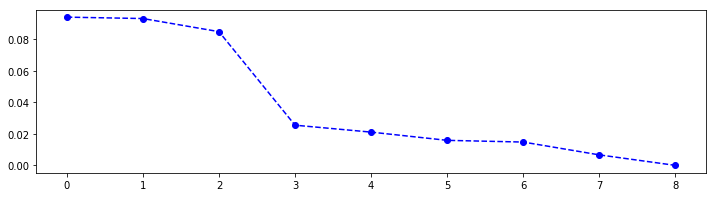

In [44]:
variaveis = X.columns.values
MI = pd.DataFrame(variaveis,scores).reset_index().rename(columns={'index':'score',0:'variavel'})
MI = MI.sort_values(by='score',ascending=False).reset_index().drop(['index'],axis=1)
# MI['score'] = MI['score']/MI['score'][0]
plt.figure(figsize=(12,3))
plt.plot(MI['score'],'bo')
plt.plot(MI['score'],'b--')

In [45]:
MI

,score,variavel
0,0.094118,Feature 1
1,0.093222,dog
2,0.084907,cat
3,0.025521,Feature 3
4,0.021117,Feature 2
5,0.015896,Feature 4
6,0.014809,Feature 5
7,0.006662,sat
8,0.000000,mat


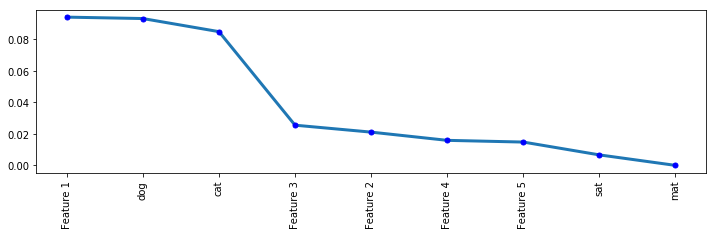

In [46]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(12, 3))

x_plot=MI.index[:50]
y_plot=MI['score'][:50]

my_xticks = list(MI['variavel'])
plt.xticks(x_plot, my_xticks)
plt.xticks(rotation=90)
plt.plot(x_plot, y_plot, linewidth = 3.0)
plt.plot(x_plot, y_plot, 'bo', ms = 5.0)
plt.show()

#### check correlation between strongest variables

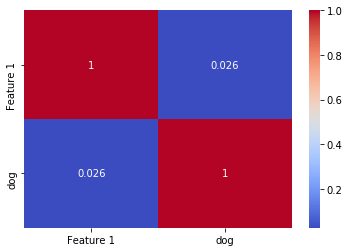

In [47]:
tips = df.loc[:,df.columns.isin(['dog','Feature 1'])]
tc = tips.corr()
sns.heatmap(tc,annot=True,cmap='coolwarm',)

### 3) Check for best estimators

#### quick analysis using logistic regression

In [48]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train,y_train)
y_pred_test = model.predict_proba(X_test)

#### performance of the model measured in terms of KS

In [49]:
from scipy import stats
stats.ks_2samp(y_pred_test[:,1][y_test == 1.0], y_pred_test[:,1][y_test == 0.0])[0]

0.450257882558962

#### prepare dataset for cross validation

In [50]:
from sklearn.metrics.scorer import make_scorer
from scipy import stats

def score_da_metrica(y_test, y_hat):
    maus = y_hat[:,1]
    return stats.ks_2samp(y_hat[:,1][y_test == 1.0], y_hat[:,1][y_test == 0.0])[0]

K_S = make_scorer(score_da_metrica, needs_proba = True)

In [51]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

In [52]:
%%time

from sklearn.ensemble import (ExtraTreesClassifier, RandomForestClassifier, 
                              AdaBoostClassifier, GradientBoostingClassifier)

from sklearn.neural_network import MLPClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression

LogRegr = cross_validate(LogisticRegression(),X_train, y_train,cv = 5,scoring=({'KS':K_S}))

LogLass = cross_validate(LogisticRegression(penalty='l1'),X_train, y_train,cv = 5,scoring=({'KS':K_S}))

GradBoost = cross_validate(GradientBoostingClassifier(),X_train, y_train,cv=5,scoring=({'K_S':K_S}))

RandForest = cross_validate(RandomForestClassifier(),X_train, y_train,cv=5,scoring=({'K_S':K_S}))

ExtraTrees = cross_validate(ExtraTreesClassifier(),X_train, y_train,cv=5,scoring=({'K_S':K_S}))

KNN = cross_validate(KNeighborsClassifier(),X_train, y_train,cv=5,scoring=({'K_S':K_S}))

MLP = cross_validate(MLPClassifier(),X_train, y_train,cv=5,scoring=({'K_S':K_S}))

CPU times: user 10.1 s, sys: 483 ms, total: 10.6 s
Wall time: 10.5 s


In [53]:
dff = pd.DataFrame(data=[LogRegr['test_KS'],LogLass['test_KS'],GradBoost['test_K_S'],RandForest['test_K_S'],
                         ExtraTrees['test_K_S'],KNN['test_K_S'],MLP['test_K_S']],    
                   index=['LogRegr','LogLass','GradBoost','RandForest','ExtraTrees','KNN','MLP']).transpose()

#### verify which techniques will perform better for the given dataset (just as a matter of illustration, some of the techniques might not be applicable to the example)

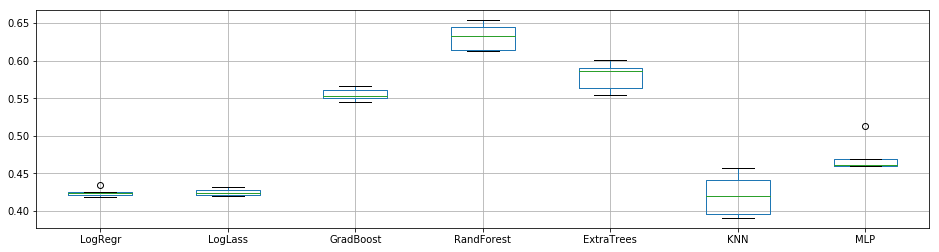

In [54]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
 
plt.subplots(1, 1, figsize=(16, 4))
dff.boxplot(figsize=[20,5],grid=True,fontsize=10)
plt.show()

### 4) Apply GridSearchCV on best estimator

#### choose specific technique (GradBoost) and apply GridSearchCV in order to determine the best parameters to fit the model

In [55]:
%%time
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

GradBoost = cross_validate(GradientBoostingClassifier(),X_train, y_train,cv=5,scoring=({'K_S':K_S}))


parametros = {'loss':['deviance'], 
              'learning_rate':[0.1,0.2,0.5], 
              'n_estimators':[100], 
              'subsample':[1.0], 
              'criterion':['friedman_mse'], 
              'min_samples_split':[2,5], 
              'min_samples_leaf':[1,2,5], 
              'min_weight_fraction_leaf':[0.0,0.5], 
              'max_depth':[3,7], 
              'min_impurity_decrease':[0.0], 
              'min_impurity_split':[None], 
              'init':[None], 
              'random_state':[101], 
              'max_features':[None], 
              'verbose':[0], 
              'max_leaf_nodes':[None], 
              'warm_start':[False], 
              'presort':['auto']}

clf_XGB = GridSearchCV(estimator = GradientBoostingClassifier(),
                         param_grid = parametros,
                         cv = 5,n_jobs = 20,scoring=K_S)

clf_XGB.fit(X_train,y_train)

CPU times: user 5.18 s, sys: 244 ms, total: 5.42 s
Wall time: 1min 25s


#### assemble performance dataframe

In [56]:
std    = [x[2] for x in clf_XGB.grid_scores_]
params = [x[0] for x in clf_XGB.grid_scores_]
df_xgb = pd.concat([pd.DataFrame(std),pd.DataFrame(params)],axis=1)

In [57]:
std = pd.DataFrame(std).transpose()
std = std.reindex_axis(std.mean().sort_values().index, axis=1)
std

/Users/tiagodosreis/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  


,35,29,31,33,37,39,41,43,45,47,...,66,60,68,70,40,62,46,44,38,42
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.694193,0.688557,0.678351,0.678351,0.661897,0.684717,0.680726,0.680726,0.696288,0.694437
1,0.13244,0.13244,0.13244,0.13244,0.13244,0.13244,0.13244,0.13244,0.13244,0.13244,...,0.684986,0.696830,0.688623,0.688623,0.687426,0.693194,0.687449,0.687449,0.686360,0.691364
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.686345,0.680793,0.722300,0.722300,0.701594,0.681881,0.695183,0.695183,0.687679,0.712282
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.657323,0.669817,0.666920,0.666920,0.701686,0.676228,0.688813,0.688813,0.685870,0.679600
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.693995,0.680980,0.662693,0.662693,0.672051,0.689722,0.674898,0.674898,0.671009,0.680122


In [58]:
std.columns.values
graf = []
for var in list(std.columns.values):
    graf.append(std[var].values)

Text(0.5,0,'test number')

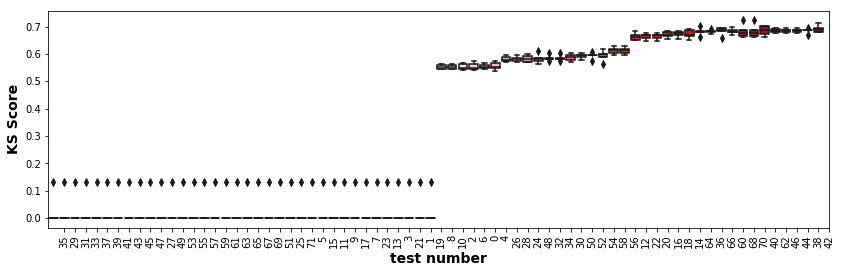

In [59]:
plt.figure(figsize=(14,4))
sns.boxplot(data=graf,palette='seismic')
plt.xticks(np.linspace(1,72,72).astype(int),std.columns.values,rotation='vertical')
plt.ylabel('KS Score',fontsize=14,fontweight='bold')
plt.xlabel('test number',fontsize=14,fontweight='bold')

#### analyze best performing models

Text(0.5,1,'Test Sample')

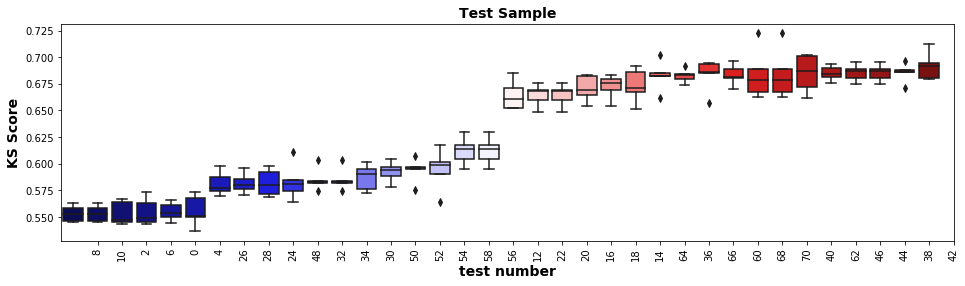

In [60]:
plt.figure(figsize=(16,4))
sns.boxplot(data=graf[36:],palette='seismic')
plt.xticks(np.linspace(1,36,36).astype(int),std.columns.values[36:],rotation='vertical')
plt.ylabel('KS Score',fontsize=14,fontweight='bold')
plt.xlabel('test number',fontsize=14,fontweight='bold')
plt.title('Test Sample',fontsize=14,fontweight='bold')

#### define which model to choose (if performance is similar, choose the simplest one)

In [61]:
df_xgb.transpose()[[44,42]]

,44,42
0,0.680726,0.694437
1,0.687449,0.691364
2,0.695183,0.712282
3,0.688813,0.6796
4,0.674898,0.680122
criterion,friedman_mse,friedman_mse
init,None,None
learning_rate,0.2,0.2
loss,deviance,deviance
max_depth,7,7


#### apply chosen model on training set and validate on test set

In [62]:
%%time

final_model = GradientBoostingClassifier(
                                   learning_rate=0.2, 
                                   min_samples_split=2, 
                                   min_samples_leaf=5, 
                                   max_depth=7, 
                                   random_state=101, 
                                   )

final_model.fit(X_train,y_train)

# probabilistic prediction
y_hat_test  = final_model.predict_proba(X_test)

#binary prediction
y_hat_bin   = final_model.predict(X_test) 

CPU times: user 1.38 s, sys: 5.26 ms, total: 1.39 s
Wall time: 1.39 s


#### binary validation $\rightarrow$ confusion matrix (normalized)

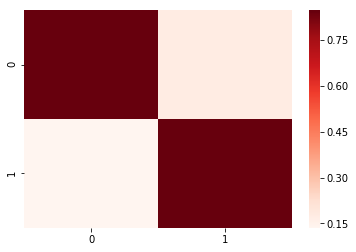

In [63]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_hat_bin) / \
            confusion_matrix(y_test, y_hat_bin).astype(np.float).sum(axis=1),cmap='Reds')

#### prob validation $\rightarrow$ on test sample only
#### a) validate performance on test set (KS)

In [64]:
stats.ks_2samp(y_hat_test[:,1][y_test == 1.0], y_hat_test[:,1][y_test == 0.0])[0]

0.6961531086109799

#### b) ROC curve

In [65]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_hat_test[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)

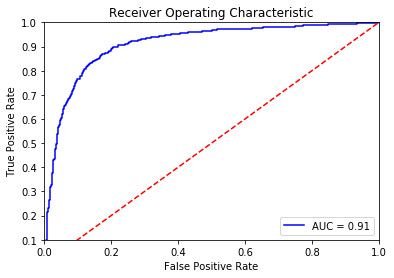

In [66]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.1,1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 5) Final Validation $\rightarrow$ apply model on 'out-of-sample/out-of-time' dataset

#### check range of values to simulate a random dataframe

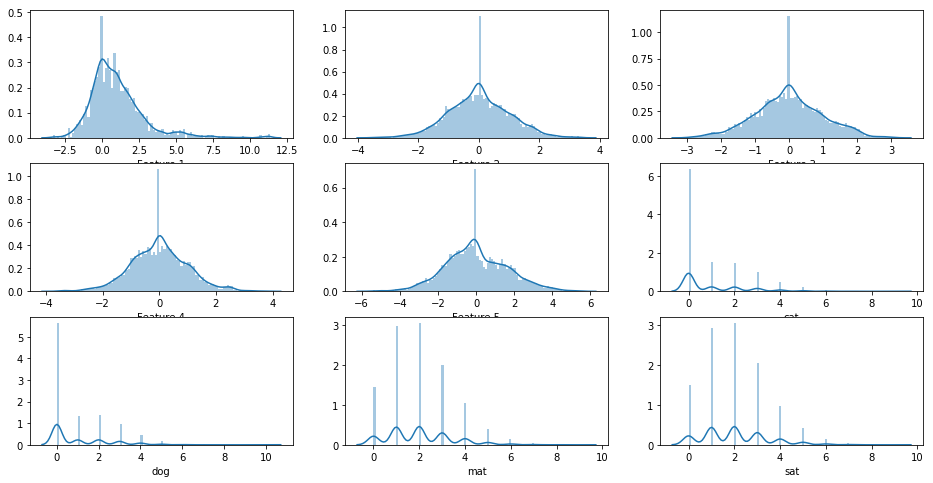

In [67]:
dist = df.loc[:,~(df.columns.isin(['User ID','Feature 7','0']))].fillna(0)
plt.figure(figsize=(16,8))
for i in range(len(dist.columns)):
    plt.subplot(3,3,i+1)
    sns.distplot(dist[str(dist.columns.values[i])],bins=100,)
    plt.tight_layout

#### generate random dataframe

In [69]:
df_sim = pd.DataFrame({'Feature 1': np.random.randn(1,100)[0],
                       'Feature 2': np.random.randn(1,100)[0],
                       'Feature 3': np.random.randn(1,100)[0],
                       'Feature 4': np.random.randn(1,100)[0],
                       'Feature 5': np.random.randn(1,100)[0],
                       'cat':       np.random.randint(0, 4, 100),
                       'dog':       np.random.randint(0, 4, 100),
                       'mat':       np.random.randint(0, 5, 100),
                       'sat':       np.random.randint(0, 5, 100)})

In [70]:
df_sim.head()

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,cat,dog,mat,sat
0,-0.730694,0.705361,-2.705943,-0.626932,-0.375981,1,0,2,4
1,-2.819292,0.036244,-0.634688,0.277455,1.185535,1,3,4,3
2,0.346602,-1.111494,-0.733005,0.126587,-0.828462,3,0,4,1
3,0.479925,0.581843,1.312917,-0.642541,-0.408041,3,2,2,4
4,-0.195616,-0.655518,2.003135,1.779265,-0.990924,3,2,3,4


#### predict binary and probabilistic chance of binary target 'Feature 7'

In [73]:
y_final_prob = pd.DataFrame(final_model.predict_proba(df_sim),index=df_sim.index)
y_final_bin  = pd.DataFrame(final_model.predict(df_sim),index=df_sim.index)

#### check distribution  (proportion of good and bad)

In [80]:
y_final_bin.sum()[0]/y_final_bin.count()[0]

0.52

In [82]:
df['Feature 7'].sum()/df['Feature 7'].count()

0.4609422186430441

#### insert final probability value on simulated dataframe

In [90]:
df_final = pd.concat([df_sim,y_final_prob],axis=1).rename(columns={0:'prob_0',1:'prob_1'})
df_final = pd.concat([df_final,y_final_bin],axis=1).rename(columns={0:'prob_bin'})

In [91]:
df_final

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,cat,dog,mat,sat,prob_0,prob_1,prob_bin
0,-0.730694,0.705361,-2.705943,-0.626932,-0.375981,1,0,2,4,0.561029,0.438971,0
1,-2.819292,0.036244,-0.634688,0.277455,1.185535,1,3,4,3,0.067698,0.932302,1
2,0.346602,-1.111494,-0.733005,0.126587,-0.828462,3,0,4,1,0.983103,0.016897,0
3,0.479925,0.581843,1.312917,-0.642541,-0.408041,3,2,2,4,0.390589,0.609411,1
4,-0.195616,-0.655518,2.003135,1.779265,-0.990924,3,2,3,4,0.912329,0.087671,0
5,-0.489112,0.916598,0.074943,0.822183,-0.319854,3,2,0,1,0.265989,0.734011,1
6,0.251957,-0.753519,-0.000986,0.319756,1.046565,2,3,4,0,0.376797,0.623203,1
7,0.020627,-0.933413,-0.018910,0.476295,0.937953,0,3,3,3,0.199472,0.800528,1
8,-0.598175,0.056951,-0.096769,-1.151336,-1.477252,1,0,4,2,0.669119,0.330881,0
9,-1.007457,0.078003,-0.284620,-0.616338,-0.271026,2,3,2,1,0.048610,0.951390,1
